# Introduction






We are tasked with predicting the forest cover type (the predominant kind of tree cover). The forest cover type dataset was originally donated to the UCI machine learning repository on 1998-08-01. The data set takes from four areas in the Roosevelt National Forrest, here in northern Colorado. The observations are taken from 30m x 30m patches of forest.

The true forest cover type for a given 30m x 30m area was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were derived from data obtained from the US Geological Survey and USFS. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.
There are seven cover type classes:
Spruce/Fir

Their are seven cover type classes:  
* Spruce/Fir
* Lodgepole Pine
* Ponderosa
* Cottonwood/Willow
* Aspen
* Douglas-fir
* Krummholz

There is a significant class size difference which we will attempt to overcome using oversampling techniques. The UCI forrest cover type data set contains 581,012 rows. The size of the dataset will be reduced by using resampling techniques to allow for faster run times. Then we will compare the results using KNN and Random Forest classifies.





# Sources that helped

* Class notebooks for PCA, KNN and helper functions/data visualization 

* https://towardsdatascience.com/predicting-forest-cover-types-with-the-machine-learning-workflow-1f6f049bf4df

* https://www.kaggle.com/gcdatkin/forest-cover-type-prediction-class-imbalance


# Setup




* Imports
* Load Dataset
* Exploratory Data Analysis
  * Correalation between features 
  * Imbalanced data 
* Helper Functions
* Imbalanced Models and Performance 
  * Random Forrest
  * KNN
* Oversampling Models and Performance 
  * Random Forrest
  * KNN

* PCA
 * PCA using Oversampling
* Conclusion and Observations


# Imports 

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#load some global colors to make pretty charts 
map = sns.color_palette("rocket_r", as_cmap=True)
colors = sns.color_palette("rocket_r")


# Load Data
Let us get started by loading the dataset and selecting 10,000 random rows from the dataset. We now have a sample of 10,000 random rows from the original dataset.

In [46]:
dfLarge = pd.read_csv(r'covtype.csv')
df = dfLarge.sample(n = 10000, random_state=42)
df01 = df.copy()
df

Elevation  Aspect  Slope  ...  Soil_Type39  Soil_Type40  Cover_Type
250728       3351     206     27  ...            0            0           1
246788       2732     129      7  ...            0            0           2
407714       2572      24      9  ...            0            0           2
25713        2824      69     13  ...            0            0           2
21820        2529      84      5  ...            0            0           2
...           ...     ...    ...  ...          ...          ...         ...
172175       3254     264     18  ...            0            0           2
565172       2807     253     17  ...            0            0           2
485894       3222     154     28  ...            0            0           2
487255       3105     352     14  ...            0            0           2
432086       3027     307      9  ...            0            0           1

[10000 rows x 55 columns]

# Exploratory Data Analysis



In [47]:
df.describe()

Elevation        Aspect  ...   Soil_Type40    Cover_Type
count  10000.000000  10000.000000  ...  10000.000000  10000.000000
mean    2960.042700    155.888700  ...      0.013600      2.044500
std      278.386537    111.942027  ...      0.115829      1.391946
min     1893.000000      0.000000  ...      0.000000      1.000000
25%     2813.000000     59.000000  ...      0.000000      1.000000
50%     2997.000000    128.000000  ...      0.000000      2.000000
75%     3163.000000    261.000000  ...      0.000000      2.000000
max     3746.000000    360.000000  ...      1.000000      7.000000

[8 rows x 55 columns]

## Correlation Between Features

A good first step is to understand the correlation between features. Let us get started.

In [48]:
continousFeatures = df.iloc[:,0:11]
continousFeatures.describe()

Elevation  ...  Wilderness_Area1
count  10000.000000  ...      10000.000000
mean    2960.042700  ...          0.443900
std      278.386537  ...          0.496868
min     1893.000000  ...          0.000000
25%     2813.000000  ...          0.000000
50%     2997.000000  ...          0.000000
75%     3163.000000  ...          1.000000
max     3746.000000  ...          1.000000

[8 rows x 11 columns]

Continuous data can be used to explore correlations between features. It has been extracted that from our data frame. Extracting the continuous data allows us to draw inferences from correlation matrices to determine highly correlated features.

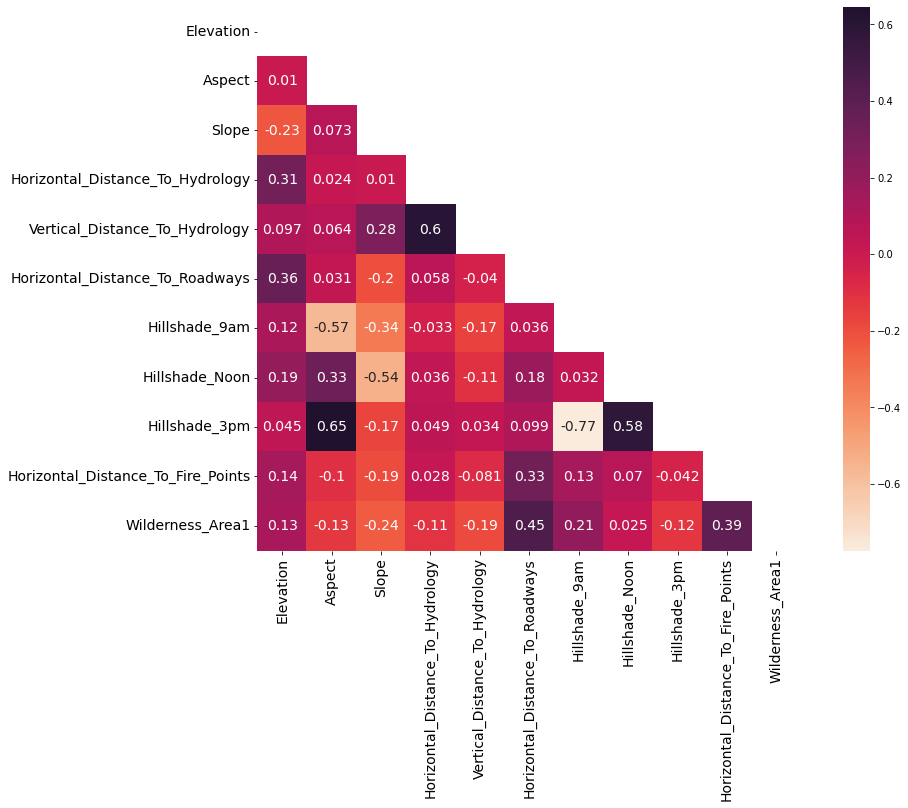

In [49]:
plt.subplots(figsize=(15,10))

continousFeaturesCorr = continousFeatures.corr()

matrix = np.triu(continousFeaturesCorr)

sns.heatmap(continousFeaturesCorr,  center=0,  mask=matrix,  square=True, annot=True, annot_kws={"size": 14},cmap=map)

plt.xticks(size=14)
plt.yticks(size=14)

plt.show()

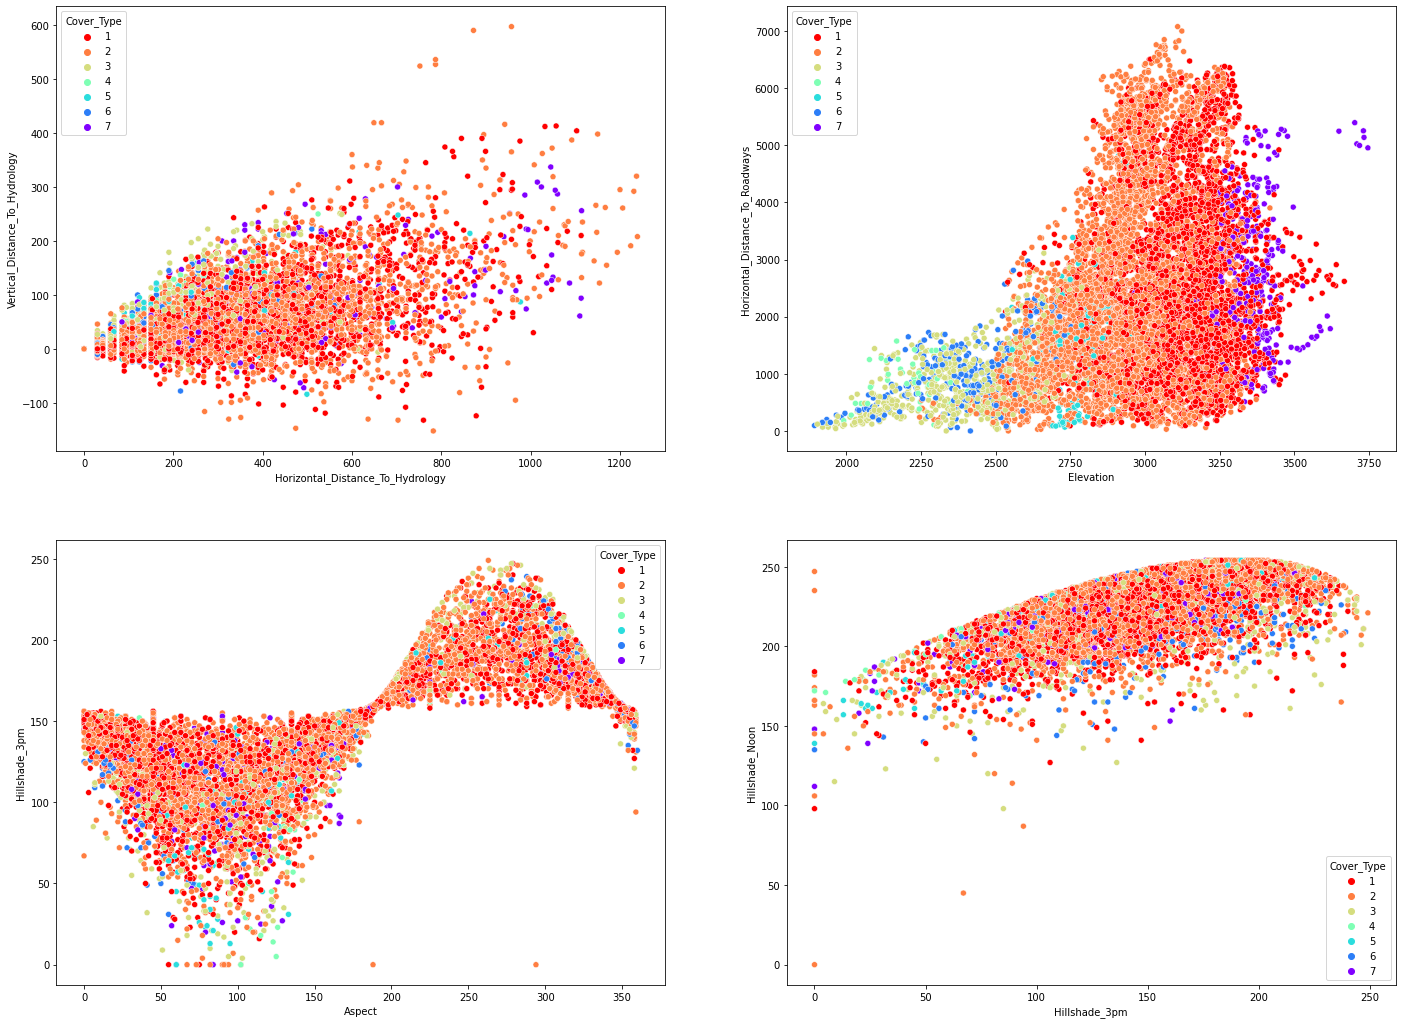

In [50]:
fig, ax = plt.subplots(2,2, figsize=(24,18))

sns.scatterplot(data=df, x="Horizontal_Distance_To_Hydrology", y="Vertical_Distance_To_Hydrology", hue="Cover_Type", legend='full', palette='rainbow_r', ax=ax[0,0])
sns.scatterplot(data=df, x="Elevation", y="Horizontal_Distance_To_Roadways", hue="Cover_Type", legend='full', palette='rainbow_r', ax=ax[0,1])
sns.scatterplot(data=df, x="Aspect", y="Hillshade_3pm", hue="Cover_Type", legend='full', palette='rainbow_r', ax=ax[1,0])
sns.scatterplot(data=df, x="Hillshade_3pm", y="Hillshade_Noon", hue="Cover_Type", legend='full', palette='rainbow_r', ax=ax[1,1])
plt.show()


Let's take a glance at the features with correlation greater than 0.5. These feature have a positive correlation.



* Hillshade_3pm and Aspect represent a sigmoid function relationship. Cover types 3, 4, 5 are concetreted at the edges of the scatter plot while Cover Types 1, 2 are the majority of the data points hinting our model may have issues with cover types 3, 4, 5.

* Vertical_Distance_To_Hydrology and Horizontal_Distance_To_Hydrology represent a linear function but more spread out.

* Horizontal_Distance_To_Hydrology
Elevation and Horizontal_Distance_To_Roadways is a spread out linear function. Cover Type 1, 2, and 7 has the highest elevation.

* Hillshade_Noon and Hillshade_3pm
Cover Type 1, 2, 6 and 7 have a higher hillshade index at noon and 3pm.
Cover Type 4 and 5 have a lower hillshade index at noon and 3pm.

## Begin to explore the class imbalance

There is a large class imbalance. There are many more instances of classes 1 and 2.  This presents a difficult challenge for our models. If they have more experience with one class that may dominate the classifications. We will analyze our models with and without class imbalances

First check for missing values

There are no missing values so there is no need to drop any features.





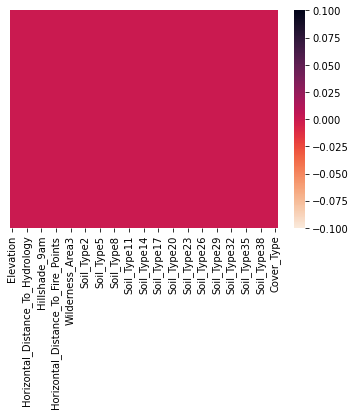

In [51]:
sns.heatmap(df.isnull(),yticklabels=False,cmap=map)

if(df.isnull().sum().sum() == 0):
  print('There are no missing values so there is no need to drop any features.')
  print("\n\n")
else:
  print('There aremissing values')
  print(df.isnull().sum())



In [52]:
df['Cover_Type'] = df['Cover_Type']-1

In [53]:
df['Cover_Type'].value_counts()

1    4841
0    3683
2     623
6     347
5     299
4     160
3      47
Name: Cover_Type, dtype: int64

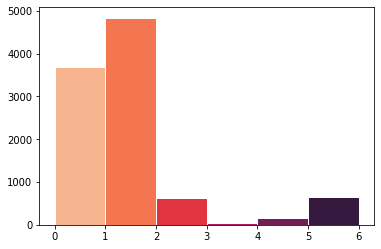

In [54]:
N, bins, patches = plt.hist(df['Cover_Type'], bins=6, edgecolor='white', linewidth=1)

for i in range(0,6):
    patches[i].set_facecolor(colors[i])

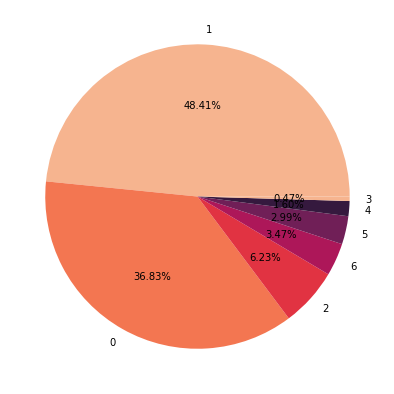

In [55]:
plt.figure(figsize=(7,7))

plt.pie(df['Cover_Type'].value_counts().values, labels=df['Cover_Type'].value_counts().keys(), autopct='%.2f%%', colors=colors)
plt.show()

Visualizing the class imbalance shows that classes 3, 4, 5, and 6 are poorly represented.

## Some helpers
* split_and_scale(): This function is from our class notebooks. It creates target data and feature data. Then split the data into training and testing sets.

* make_cm_1(): This function is from our class notebooks. It takes in predicted and true data and returns a confusion matrix

* creatReport(): evaluates the model using a classification report and confusion matrix. 

* def plot_if_only_two_dim(): This function is taken from the class PCA notebook. it plots PCA if its two dimensions

* def find_subspace(): Preforms PCA on test and training data. 

In [56]:
def split_and_scale(df):
    df = df.copy()
    y = df['Cover_Type'].copy()
    X = df.drop('Cover_Type', axis=1).copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)    
    return X_train, X_test, y_train, y_test

In [57]:
def make_cm_1(y, y1) :
  matrix  = confusion_matrix(y1,y)
  return matrix

In [58]:
def createReport(y_test,ypredicted):
  cf_matrix = make_cm_1(y_test,ypredicted)
  clr1 = classification_report(y_test, ypredicted)
  plt.figure(figsize=(8,8))
  sns.heatmap(cf_matrix, annot=True, fmt='g', cmap = map )
  print(clr1)


In [59]:

def plot_if_only_two_dim(X, y) :
    if X.shape[1] == 2 :
        my_colors =  sns.color_palette("Spectral", 7)

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.scatter(X[:,0], X[:,1], c=[my_colors[i] for i in y])
        ax.set_xlabel('First PC')
        ax.set_ylabel('Second PC')
    else :
        print("Not plotting since more than two dimensions")
        
     

In [60]:
from sklearn.decomposition import PCA
def find_subspace (X_train, X_test, subspace_dims) :
  pca = PCA(n_components=subspace_dims)
  pca.fit(X_test)
  pca.fit(X_train)

  Xs = pca.transform(X_train)
  tests = pca.transform(X_test)
  return Xs, tests, pca

# Imbalanced Models and Performance

Lets first see how our models will perform on teh original imbalanced data. 

## Random Forrest


In [61]:
imbalanced_data = df.copy()

X_train, X_test, y_train, y_test = split_and_scale(imbalanced_data)

In [62]:
rfc = RandomForestClassifier(n_estimators = 200, bootstrap=True, max_depth=21)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=21, n_estimators=200)

In [63]:
pred = rfc.predict(X_test)

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1124
           1       0.81      0.86      0.83      1436
           2       0.74      0.86      0.80       176
           3       0.71      0.38      0.50        13
           4       1.00      0.32      0.48        47
           5       0.82      0.38      0.51        96
           6       0.85      0.58      0.69       108

    accuracy                           0.80      3000
   macro avg       0.82      0.60      0.66      3000
weighted avg       0.80      0.80      0.80      3000



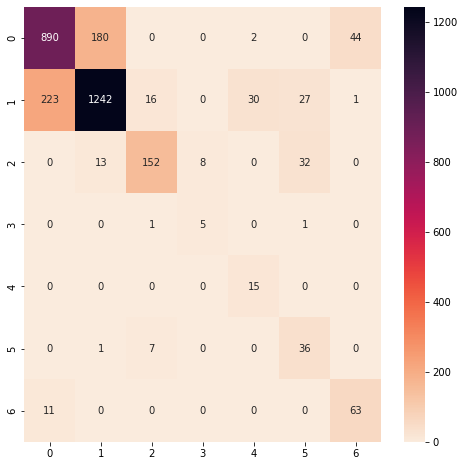

In [64]:
createReport(y_test, pred)

We achieved an accuracy of 79% but the majority of our correct classifications have been for the majority classes. Many classes have low precision and recall due to them being under repersented. The class imbalance led to imbalanced results from the model. 



Text(0, 0.5, 'Accuracy Rate')

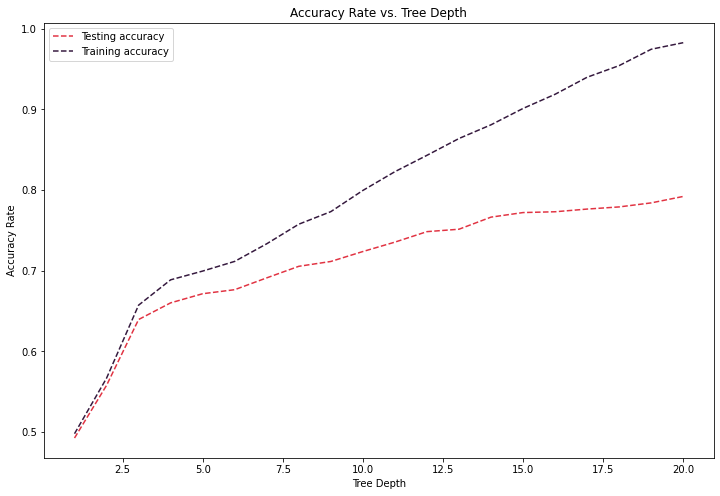

In [65]:
accuracy_rate = []
training_acc = []

for i in range(1,21):   
    dtree = RandomForestClassifier(max_depth=i)
    dtree.fit(X_train, y_train) 
    accuracy_rate.append(dtree.score(X_test, y_test))
    training_acc.append(dtree.score(X_train, y_train))


plt.figure(figsize=(12,8))
plt.plot(np.arange(1,21), accuracy_rate,color=colors[2], linestyle='dashed', label='Testing accuracy')
plt.plot(np.arange(1,21), training_acc,color=colors[5], linestyle='dashed', label='Training accuracy')
plt.legend(loc="upper left")
plt.title('Accuracy Rate vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy Rate')

Plotting the accuracy rate vs tree depth shows that our model is overfitting because the testing accuracy is less than the training accuracy. The issue here is from the confusion matrix we can see our model is overfitting only to the majority classes leaving the minority classes behind. We will see a solution to this when we get to oversampling further in the notebook. This can be seen as we are achieving accuracy near the training accuracy but it suddenly starts to level off at 0.75. This indicated that it did well with some classes (ie the majority) and quickly lost accuracy on the minority classes.  

## KNN

Lets get started with using a KNN model. We will first need to create it and fit the model to our training data. 


In [66]:
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1124
           1       0.75      0.82      0.78      1436
           2       0.66      0.68      0.67       176
           3       0.70      0.54      0.61        13
           4       0.79      0.23      0.36        47
           5       0.63      0.32      0.43        96
           6       0.86      0.45      0.59       108

    accuracy                           0.74      3000
   macro avg       0.73      0.54      0.60      3000
weighted avg       0.74      0.74      0.73      3000



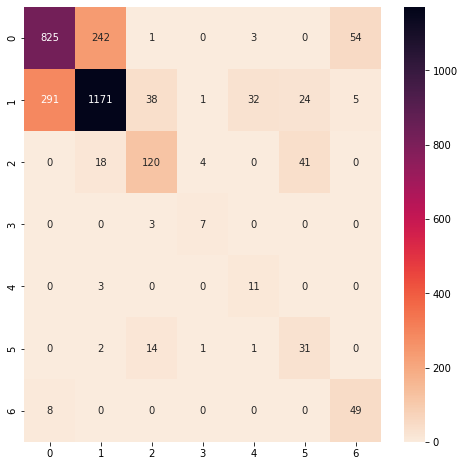

In [67]:
ypred = KNN.predict(X_test)
createReport(y_test, ypred)

Just glancing at the accuracy we may be tempted to assume that KNN did fairly well. However, the confusion matrix tells a different story. Our model only did well for the majority of classes. The precision for each minority class is in the range of 0.63 - 0.75 meaning that there is a high amount of false positives. The recall was in the range of around 0.23-0.68 for the minority classes and 0.86 for the two majority classes. This signifies that there are many false negatives for the minority classes, another sign our model is struggling with the imbalance classes. This is the same issue we had when using a Random Forrest Classifier. The majority of classes are taking over our model!




# Oversampling Models and Performance


Lets first identify the majoirty class. We can then transform our data to replicate our other classes in order to have the same number of samples. In the end all of our classes have the same instances. This in thoery should help our model have expiernce with all 7 classes. Lets see how our models behave now. 

In [68]:
def overSample(df):
    undersampled_data = df.copy()
    maxVal = df['Cover_Type'].value_counts()
    max = maxVal.max()

    print("Size of largest class:")
    print(max)

    class_subsets = [undersampled_data.query("Cover_Type == " + str(i)) for i in range(7)]

    for i in range(7):
        class_subsets[i] = class_subsets[i].sample(max, replace=True, random_state=123)

    undersampled_data = pd.concat(class_subsets, axis=0).sample(frac=1.0, random_state=123).reset_index(drop=True)
    return undersampled_data
undersampled_data = overSample(df)

Size of largest class:
4841


In [69]:
undersampled_data['Cover_Type'].value_counts()

6    4841
5    4841
4    4841
3    4841
2    4841
1    4841
0    4841
Name: Cover_Type, dtype: int64

Perfect! all classes have the same amount of data. Let split our dataset now in to test and train sections.

In [70]:
X_train, X_test, y_train, y_test = split_and_scale(undersampled_data)

## Random Forrest using Oversampling 

In [71]:
model2 = RandomForestClassifier(n_estimators = 200, bootstrap=True, max_depth=21)
model2.fit(X_train,y_train)

RandomForestClassifier(max_depth=21, n_estimators=200)

In [72]:
overPredict = model2.predict(X_test)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1438
           1       0.93      0.88      0.91      1500
           2       0.98      1.00      0.99      1437
           3       1.00      1.00      1.00      1431
           4       0.99      1.00      1.00      1457
           5       0.99      1.00      1.00      1478
           6       0.99      1.00      1.00      1426

    accuracy                           0.97     10167
   macro avg       0.97      0.97      0.97     10167
weighted avg       0.97      0.97      0.97     10167



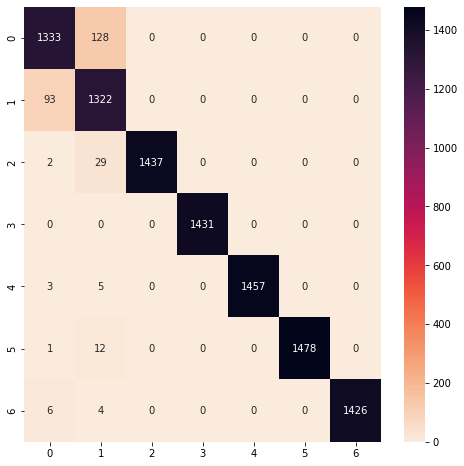

In [73]:
createReport(y_test, overPredict)

Using oversampled data our model is performing much better. All classes are being equally represented and classified with high precision. The f1 scores are also very high for all classes a sign our model is doing very well.

Text(0, 0.5, 'Accuracy Rate')

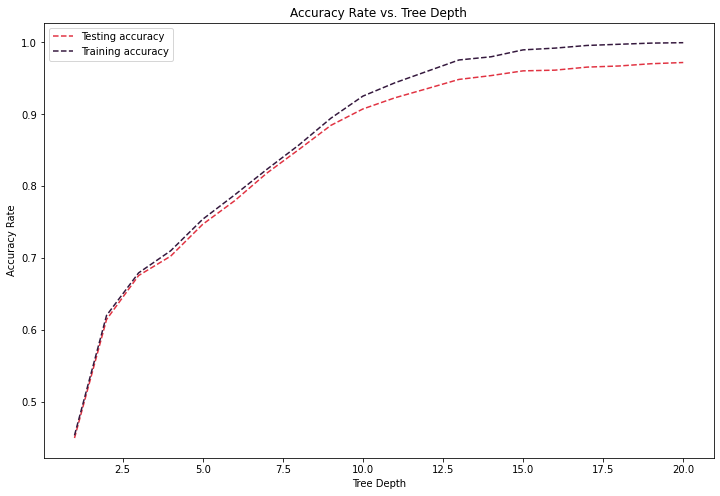

In [74]:
from sklearn.tree import DecisionTreeClassifier

accuracy_rate = []
training_acc = []

for i in range(1,21):   
    dtree = RandomForestClassifier(max_depth=i)
    dtree.fit(X_train, y_train) 
    accuracy_rate.append(dtree.score(X_test, y_test))
    training_acc.append(dtree.score(X_train, y_train))


plt.figure(figsize=(12,8))
plt.plot(np.arange(1,21), accuracy_rate,color=colors[2], linestyle='dashed', label='Testing accuracy')
plt.plot(np.arange(1,21), training_acc,color=colors[5], linestyle='dashed', label='Training accuracy')
plt.legend(loc="upper left")
plt.title('Accuracy Rate vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy Rate')

Plotting the accuracy rate vs tree depth with oversampled data shows that our model is overfitting because the testing accuracy is less than the training accuracy.

## KNN using OverSampling

In [75]:
model3 = KNeighborsClassifier()
model3.fit(X_train,y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1438
           1       0.81      0.70      0.75      1500
           2       0.95      0.98      0.97      1437
           3       1.00      1.00      1.00      1431
           4       0.95      1.00      0.97      1457
           5       0.97      1.00      0.98      1478
           6       0.94      1.00      0.97      1426

    accuracy                           0.92     10167
   macro avg       0.92      0.92      0.92     10167
weighted avg       0.92      0.92      0.92     10167



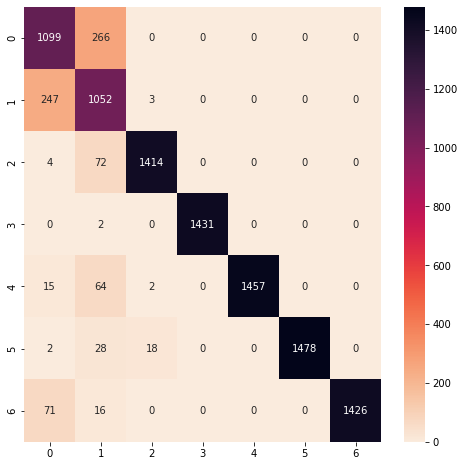

In [76]:
ypred = model3.predict(X_test)
createReport(y_test, ypred)

Our model now has higher accuracy across all classes. 

# PCA
Let us see if we can decrease the dimensionality of our data using PCA while still achieving a relatively high accuracy. We will use RandomForrestClassifier becuase it performed better then KNN. 

In [77]:
df01['Cover_Type'] = df01['Cover_Type']-1
X_train, X_test, y_train, y_test = split_and_scale(df01)

              precision    recall  f1-score   support

           0       0.48      0.46      0.47      1124
           1       0.54      0.62      0.58      1436
           2       0.33      0.31      0.32       176
           3       0.25      0.08      0.12        13
           4       0.33      0.11      0.16        47
           5       0.16      0.09      0.12        96
           6       0.10      0.04      0.05       108

    accuracy                           0.49      3000
   macro avg       0.31      0.24      0.26      3000
weighted avg       0.48      0.49      0.48      3000



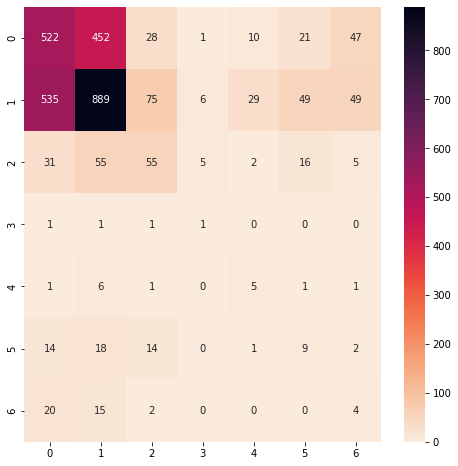

In [78]:
Xs_trainr, Xs_testr, pcar = find_subspace(X_train, X_test, 2)

model41 = RandomForestClassifier()
model41.fit(Xs_trainr,y_train)
model41.score(Xs_testr,y_test)
pred = model41.predict(Xs_testr)
createReport(y_test, pred)

We can see some class seperation but its clear a subspace of 2 is not enough to achieve results when using all features. Lets try to increase to 4 dimensions.

In [79]:
Xs_trainr, Xs_testr, pcar = find_subspace(X_train, X_test, 4)

model4 = RandomForestClassifier()
model4.fit(Xs_trainr,y_train)
model4.score(Xs_testr,y_test)

0.748

Using More PCs helped but our model is still struggling due to the class imbalance. 

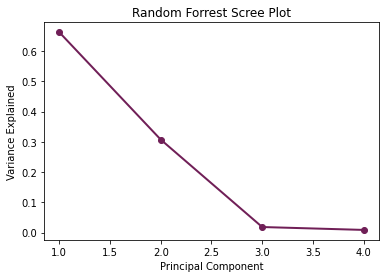

[0.66211142 0.30716221 0.01814487 0.00860132]


In [80]:
PC_values = np.arange(pcar.n_components_) + 1
plt.plot(PC_values, pcar.explained_variance_ratio_, 'o-', linewidth=2, color=colors[4])
plt.title('Random Forrest Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print(pcar.explained_variance_ratio_)

## PCA Using Oversampling

In [81]:
X_train, X_test, y_train, y_test = split_and_scale(undersampled_data)

In [82]:
Xs_trainr, Xs_testr, pcar = find_subspace(X_train, X_test, 2)

model42 = RandomForestClassifier()
model42.fit(Xs_trainr,y_train)
model42.score(Xs_testr,y_test)


#pred = model42.predict(Xs_testr)
#createReport(y_test, pred)

0.9283957903019573

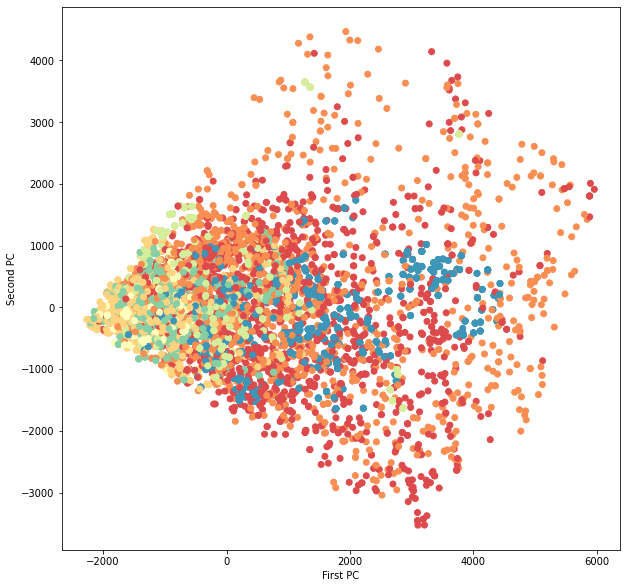

In [83]:
plot_if_only_two_dim(Xs_testr, y_test) 

There is minimal class seperation when using 2 PCs lets try 4

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1438
           1       0.92      0.85      0.89      1500
           2       0.97      1.00      0.99      1437
           3       1.00      1.00      1.00      1431
           4       0.99      1.00      1.00      1457
           5       0.99      1.00      1.00      1478
           6       0.98      1.00      0.99      1426

    accuracy                           0.97     10167
   macro avg       0.97      0.97      0.97     10167
weighted avg       0.97      0.97      0.97     10167



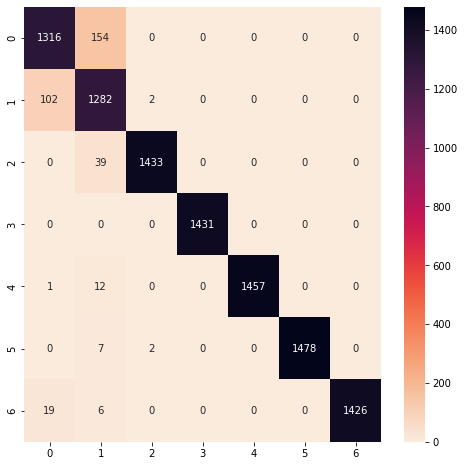

In [84]:
Xs_trainr, Xs_testr, pcar = find_subspace(X_train, X_test, 4)

model5 = RandomForestClassifier()
model5.fit(Xs_trainr,y_train)
model5.score(Xs_testr,y_test)

pred = model5.predict(Xs_testr)
createReport(y_test, pred)

Our Model is now performing well when using 4 PCs. The precision and recall are high indicating low amounts of FP and FN. This is reflected by high f1 scores. This shows we can achieve similar results with fewer features. 

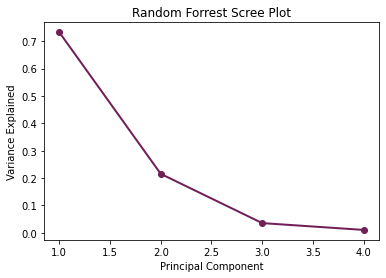

[0.73285856 0.21544754 0.03556516 0.01065609]


In [85]:
PC_values = np.arange(pcar.n_components_) + 1
plt.plot(PC_values, pcar.explained_variance_ratio_, 'o-', linewidth=2, color=colors[4])
plt.title('Random Forrest Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print(pcar.explained_variance_ratio_)

# Conclusion 

When we ran our models using the imbalanced class data we performed well for the majority classes but performed poorly for the minority classes.

* The imbalanced Random Forrest classifier had an accuracy of 72% which may not seem that bad. However, if we dive into the classification report and confusion matrix we see that we are classifying the majority classes right but everything else is not classified right. The precision for each class is in the range of 0.60 - 0.80. This tells us that there is a high amount of false positives for all classes. The recall was in the range of around 0.30-0.70 for the minority classes and 0.86 for the two majority classes. This signifies that there are many false negatives for the minority classes, another sign our model is struggling with the imbalance classes.

* The imbalanced KNN Classifier had an accuracy of 0.74, however, it struggled with the same issues as the Random Forrest Classifier. The minority classes were not well classified and had large amounts of FP and FN which in turn led to low f1 scores.

* Oversampled Random Forrest Classifier had an accuracy of 0.97. When taking a deeper look we see that our precision ranges from 0.91-1.00. This signifies our model is classifying the majority of classes correctly with low amounts of false positives. We also see that the recall ranges from 0.92-1.00. The recall and precision combined to give us f1 scores 0.92-1.00. In total it is shown that our model performed much better when using oversampling by classifying all classes with high accuracy.

* Oversampled KNN had similar results to Random Forrest but the accuracy was 0.92. This along with slightly lower precision, recall, and f1 scores signify that our model did better with oversampling when using the Random Forrest Classifier.

* Principle Component Analysis with oversampled data showed us that we could get relatively high accuracy when we reduce our data dimensionality. This is useful for large datasets with many features. When using two PCA's the accuracy was not very high and looking at the graph visualizing the two pcas there is wasnt much class groupings. Using greater then two PCs allows better accuracies. 

In conclusion, oversampling using the Random Forrest Classifier produced the best model for classifying forest cover types.